# Multi-Fidelity

<div class="btn btn-notebook" role="button">
    <img src="../_static/images/colab_logo_32px.png"> [Run in Google Colab](https://colab.research.google.com/drive/1Cc9TVY_Tl_boVzZDNisQnqe6Qx78svqe?usp=sharing)
</div>
<div class="btn btn-notebook" role="button">
    <img src="../_static/images/github_logo_32px.png"> [View on GitHub](https://github.com/adapt-python/notebooks/blob/d0364973c642ea4880756cef4e9f2ee8bb5e8495/Multi_fidelity.ipynb)
</div>

The following example is a 1D regression multi-fidelity issue. Blue points are low fidelity observations and orange points are high fidelity observations. The goal is to use both datasets to learn the task on the [0, 1] interval.

To tackle this challenge, we use here the parameter-based method: [RegularTransferNN](#RegularTransferNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import clone_model

from adapt.parameter_based import RegularTransferNN

## Setup

In [2]:
np.random.seed(0)
Xs = np.linspace(0, 1, 200)
ys = (1 - Xs**2) * np.sin(2 * 2 * np.pi * Xs) - Xs + 0.1 * np.random.randn(len(Xs))

Xt = Xs[:100]
yt = (1 - Xt**2) * np.sin(2 * 2 * np.pi * Xt) - Xt - 1.5
gt = (1 - Xs**2) * np.sin(2 * 2 * np.pi * Xs) - Xs - 1.5

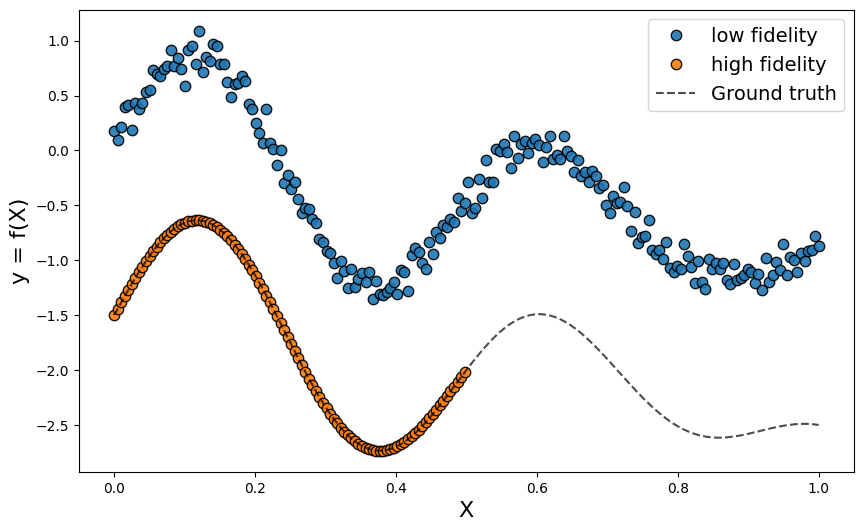

In [3]:
plt.figure(figsize=(10,6))
plt.plot(Xs, ys, '.', label="low fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xt, yt, '.', label="high fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xs, gt, c="black", alpha=0.7, ls="--", label="Ground truth")
plt.legend(fontsize=14)
plt.xlabel("X", fontsize=16)
plt.ylabel("y = f(X)", fontsize=16)
plt.show()

## Network

In [7]:
np.random.seed(0)
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(1,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

## Low fidelity only

In [8]:
np.random.seed(0)
tf.random.set_seed(0)
model_low = clone_model(model)
model_low.compile(optimizer=Adam(0.001), loss='mean_squared_error')
model_low.fit(Xs, ys, epochs=800, batch_size=34, verbose=0);

7/7 [==============================] - 0s 6ms/step


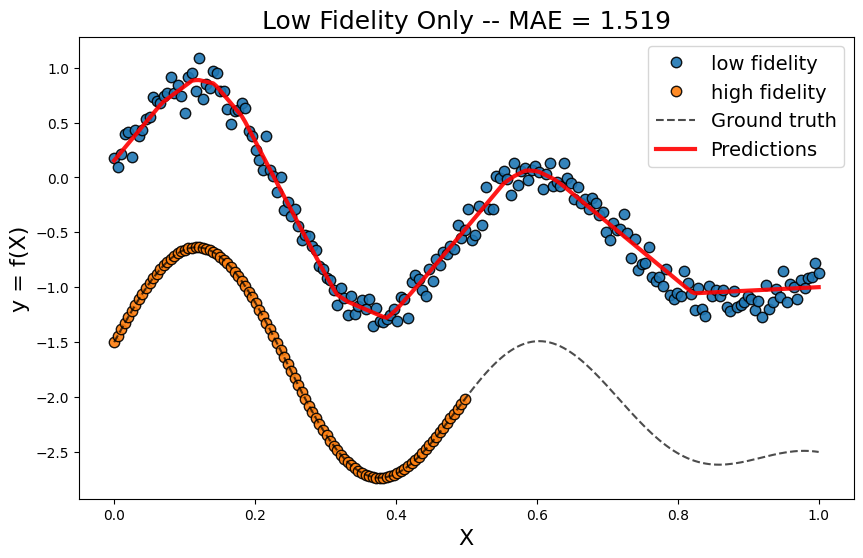

In [9]:
yp = model_low.predict(Xs.reshape(-1,1))
score = mean_absolute_error(gt.ravel(), yp.ravel())

plt.figure(figsize=(10,6))
plt.plot(Xs, ys, '.', label="low fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xt, yt, '.', label="high fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xs, gt, c="black", alpha=0.7, ls="--", label="Ground truth")
plt.plot(Xs, yp, c="red", alpha=0.9, lw=3, label="Predictions")
plt.legend(fontsize=14)
plt.xlabel("X", fontsize=16)
plt.ylabel("y = f(X)", fontsize=16)
plt.title("Low Fidelity Only -- MAE = %.3f"%score, fontsize=18)
plt.show()

## High fidelity only

In [10]:
np.random.seed(0)
tf.random.set_seed(0)
model_high = clone_model(model)
model_high.compile(optimizer=Adam(0.001), loss='mean_squared_error')
model_high.fit(Xt, yt, epochs=800, batch_size=34, verbose=0);

7/7 [==============================] - 0s 2ms/step


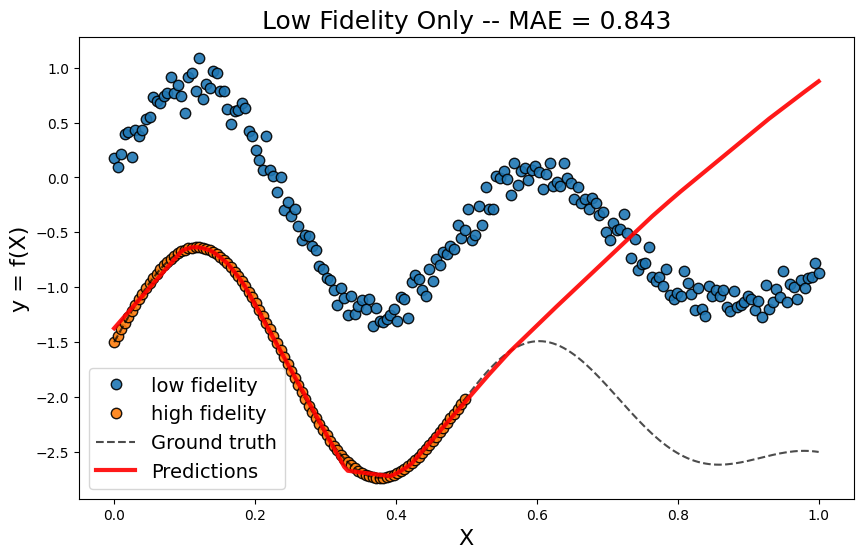

In [11]:
yp = model_high.predict(Xs.reshape(-1,1))
score = mean_absolute_error(gt.ravel(), yp.ravel())

plt.figure(figsize=(10,6))
plt.plot(Xs, ys, '.', label="low fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xt, yt, '.', label="high fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xs, gt, c="black", alpha=0.7, ls="--", label="Ground truth")
plt.plot(Xs, yp, c="red", alpha=0.9, lw=3, label="Predictions")
plt.legend(fontsize=14)
plt.xlabel("X", fontsize=16)
plt.ylabel("y = f(X)", fontsize=16)
plt.title("Low Fidelity Only -- MAE = %.3f"%score, fontsize=18)
plt.show()

## [RegularTransferNN](https://adapt-python.github.io/adapt/generated/adapt.parameter_based.RegularTransferNN.html)

In [12]:
model_reg = RegularTransferNN(model_low, lambdas=1000., random_state=1, optimizer=Adam(0.0001))
model_reg.fit(Xt.reshape(-1,1), yt, epochs=1200, batch_size=34, verbose=0);

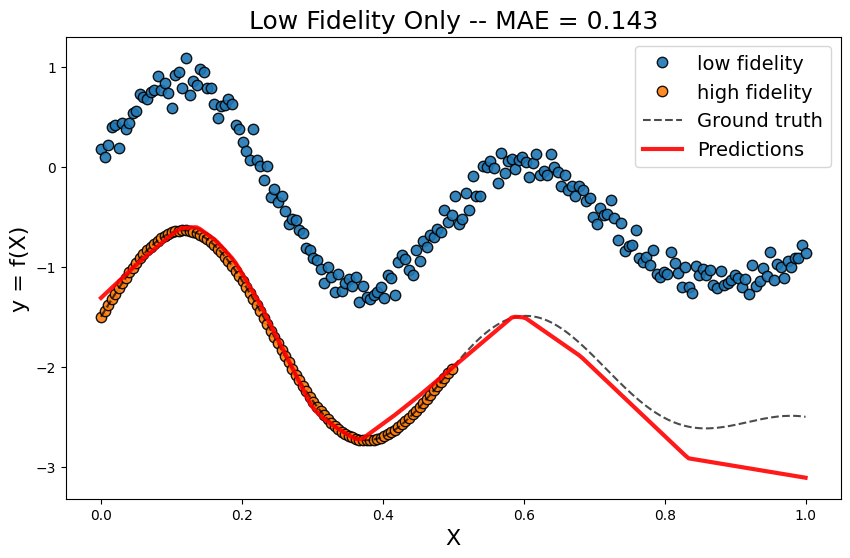

In [13]:
yp = model_reg.predict(Xs.reshape(-1,1))
score = mean_absolute_error(gt.ravel(), yp.ravel())

plt.figure(figsize=(10,6))
plt.plot(Xs, ys, '.', label="low fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xt, yt, '.', label="high fidelity", ms=15, alpha=0.9, markeredgecolor="black")
plt.plot(Xs, gt, c="black", alpha=0.7, ls="--", label="Ground truth")
plt.plot(Xs, yp, c="red", alpha=0.9, lw=3, label="Predictions")
plt.legend(fontsize=14)
plt.xlabel("X", fontsize=16)
plt.ylabel("y = f(X)", fontsize=16)
plt.title("Low Fidelity Only -- MAE = %.3f"%score, fontsize=18)
plt.show()